# Project 2: Reproducibility in Natural Language Processing



### Read Data

In [4]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

plt.style.use('seaborn-v0_8-dark')

In [5]:
!{sys.executable} -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.3 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
sou = pd.read_csv("data/SOTU.csv")

In [7]:
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

## Part 3: Advanced Text Processing - LDA and BERTopic Topic Modeling (20 pts)

**Resources:**
- LDA:
    - https://medium.com/sayahfares19/text-analysis-topic-modelling-with-spacy-gensim-4cd92ef06e06 
    - https://www.kaggle.com/code/faressayah/text-analysis-topic-modeling-with-spacy-gensim#%F0%9F%93%9A-Topic-Modeling (code for previous post)
    - https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf/ 
- BERTopic:
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_documents.html#visualize-documents-with-plotly 
    - https://maartengr.github.io/BERTopic/getting_started/visualization/visualize_topics.html 


In [8]:
from spacy import displacy
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models

/home/jovyan/.local/share/envs/sotu/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LDA

- Train an LDA model with 18 topics
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization

You may use the next two cells to process the data.

In [9]:
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not
            token.is_punct and not token.is_space and len(token.lemma_) > 3]

In [10]:
# Process all texts - note this takes ~ 5 minutes to run
processed_docs = sou['Text'].apply(preprocess_text)

To train an LDA model, use the LdaModel function that we imported a couple of cells back. The last resource linked under the LDA section is especially useful for walking through the steps we have below. *Note: one of the arguments to the LdaModel function is `random_state` which specifies the random seed for reproducibility. Please set yours to 42. Further, the last resource provided uses `LdaMulticore` which is essentially a parallelizable version of our function `LdaModel`. Use `LdaModel` instead, but the usage will be similar, except you can ignore the `iterations` and `workers` arguments..*.

In [50]:
# Build dictionary from processed_docs, which is a list of tokens extracted from our speeches
dictionary = Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5,no_above=0.5)

In [51]:
# train LDA model with 18 topics
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
model_LDA = LdaModel(corpus=corpus, id2word=dictionary, num_topics=18, random_state=42, passes=10)

In [56]:
# print the top 10 words for each topic
print("\n--- LDA Topics ---")
for idx, topic in model_LDA.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}\n")


--- LDA Topics ---
Topic: 0 
Words: 0.004*"cent" + 0.004*"june" + 0.004*"gold" + 0.003*"island" + 0.003*"silver" + 0.003*"bond" + 0.003*"method" + 0.003*"convention" + 0.003*"indian" + 0.003*"note"

Topic: 1 
Words: 0.008*"depression" + 0.007*"program" + 0.007*"recovery" + 0.006*"budget" + 0.006*"unemployment" + 0.006*"loan" + 0.006*"activity" + 0.006*"farm" + 0.005*"emergency" + 0.005*"cent"

Topic: 2 
Words: 0.008*"dictator" + 0.005*"expression" + 0.004*"british" + 0.004*"1914" + 0.003*"impressive" + 0.003*"actual" + 0.003*"revolution" + 0.003*"schedule" + 0.003*"continent" + 0.003*"partisanship"

Topic: 3 
Words: 0.008*"forest" + 0.007*"corporation" + 0.005*"judge" + 0.005*"wrong" + 0.005*"interstate" + 0.004*"employee" + 0.003*"bureau" + 0.003*"body" + 0.003*"mountain" + 0.003*"island"

Topic: 4 
Words: 0.017*"program" + 0.014*"soviet" + 0.009*"1980" + 0.009*"u.s." + 0.008*"area" + 0.007*"major" + 0.006*"goal" + 0.006*"commitment" + 0.006*"challenge" + 0.006*"nuclear"

Topic: 5 
W

In [57]:
# print the topic distribution for the first speech
model_LDA[corpus][0]

[(11, np.float32(0.99942815))]

In [58]:
# make a visualization using pyLDAvis
pyLDAvis.enable_notebook()

lda_display = pyLDAvis.gensim_models.prepare(model_LDA, corpus, dictionary)

import os
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

html_output_path = os.path.join(output_dir, "pyLDAvis_interactive.html")
pyLDAvis.save_html(lda_display, html_output_path)
pyLDAvis.display(lda_display)

### BERTopic

- Train a BERTopic model with a `min_topic_size` of 3 *Hint: use `BERTopic` to instantiate the model and specify `min_topic_size` in here. Actually fit the model using `fit_transform`, which `docs` passed into this.*
- Output the top 10 words for each topic. 
- Output the topic distribution for the first speech
- Make a visualization of the topics (see topic_model.visualize_topics())

In [61]:
docs = sou['Text'].to_list()

In [95]:
# train the model - this takes about 30 seconds
from umap import UMAP
model = BERTopic(min_topic_size=3, umap_model=UMAP(random_state=42), verbose=True)
topics, probs = model.fit_transform(docs)

2025-11-22 01:25:53,340 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it]
2025-11-22 01:26:06,928 - BERTopic - Embedding - Completed ✓
2025-11-22 01:26:06,929 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-22 01:26:07,385 - BERTopic - Dimensionality - Completed ✓
2025-11-22 01:26:07,385 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-22 01:26:07,396 - BERTopic - Cluster - Completed ✓
2025-11-22 01:26:07,399 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-22 01:26:08,953 - BERTopic - Representation - Completed ✓


In [96]:
# remove stop words from the topics (Hint: use CountVectorizer and then .update_topics on topic_model)
vector = CountVectorizer(stop_words='english')
model.update_topics(docs, vectorizer_model=vector)

In [97]:
# output the top 10 words for each topic - hint see get_topic_info
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,73,-1_government_states_congress_year,"[government, states, congress, year, united, p...",[\nTo the Senate and House of Representatives:...
1,0,22,0_states_government_united_congress,"[states, government, united, congress, public,...",[\nFellow-Citizens of the Senate and of the Ho...
2,1,15,1_states_government_united_congress,"[states, government, united, congress, departm...",[\nFellow-Citizens of the Senate and House of ...
3,2,13,2_america_world_new_years,"[america, world, new, years, american, people,...","[\nMr. Speaker, Mr. President, my colleagues i..."
4,3,12,3_states_government_united_congress,"[states, government, united, congress, public,...",[\nFellow-Citizens of the Senate and of the Ho...
5,4,11,4_world_new_economic_program,"[world, new, economic, program, federal, years...","[\nMr. President, Mr. Speaker, Members of the ..."
6,5,11,5_world_nations_soviet_peace,"[world, nations, soviet, peace, economic, nati...","[\nMr. President, Mr. Speaker, Members of the ..."
7,6,9,6_government_states_law_united,"[government, states, law, united, congress, go...",[\nTo the Senate and House of Representatives:...
8,7,9,7_government_great_work_law,"[government, great, work, law, public, nationa...",[\nTo the Senate and House of Representatives:...
9,8,7,8_states_united_government_constitution,"[states, united, government, constitution, con...",[\nTo the Senate and House of Representatives:...


BerTOPIC is nondeterministic unless a random state is set as shown above. Since a random state is not specified for this section, we chose 42 to maintain reproducibility.

100%|██████████| 1/1 [00:14<00:00, 14.18s/it]


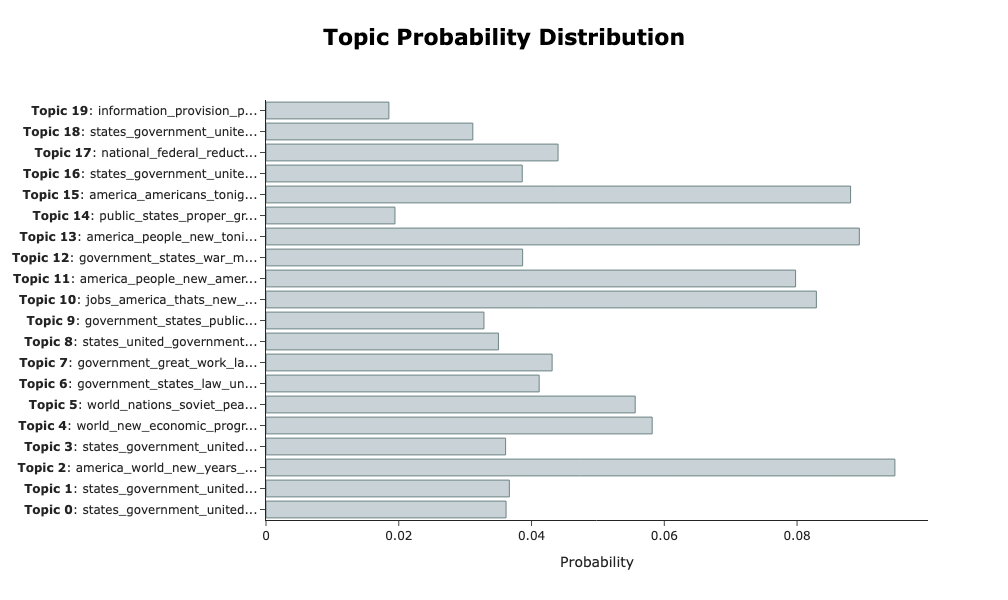

In [98]:
# output the topic distribution for the first speech
# hint: check out approximate_distribution() and visualize_distribution()
topic_distr, _ = model.approximate_distribution(docs, min_similarity=0)
fig = model.visualize_distribution(topic_distr[0])
output_path = os.path.join(output_dir, "topic_distribution_plot.png")
# fig.save_html(output_path) # bbox_inches='tight' prevents labels from being cut off
fig.write_html("outputs/viz_distribution.html")
fig.show()

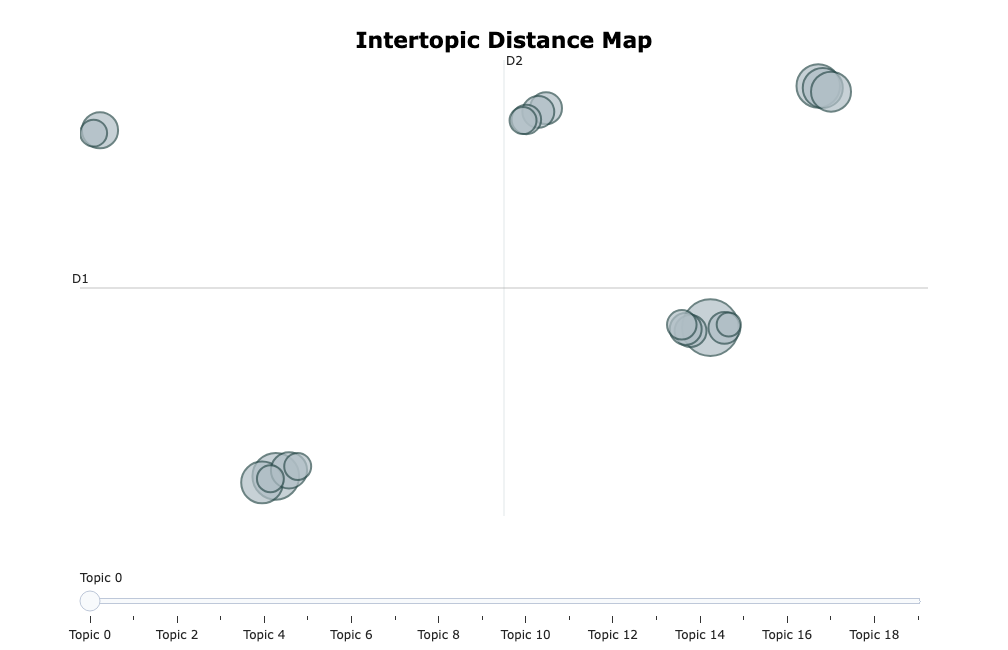

In [99]:
# run this cell to visualize the topics
fig = model.visualize_topics()
fig.write_html("outputs/topic_distribution.html")
fig.show()